This is used to calculate the accuracy of the transcriptions

In [40]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re
import pandas as pd

In [ ]:

def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_pairs(root_folder):
    pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            whisper_file = [f for f in files if f.endswith('_Whisper.txt')]
            gt_file = [f for f in files if f.endswith('.txt') and not f.endswith('_Whisper.txt')]
            if whisper_file and gt_file:
                whisper_path = os.path.join(full_path, whisper_file[0])
                gt_path = os.path.join(full_path, gt_file[0])
                pairs.append((subdir, gt_path, whisper_path))
                
    df_paths = pd.DataFrame(pairs, columns=['folder', 'gt_path', 'whisper_path'])
    return pairs, df_paths
#Measuring Word Error Rate (WER), Match Error Rate (MER), and Word Information Lost (WIL)
def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder(base_folder):
    results = []
    pairs, df_paths = get_transcript_pairs(base_folder)
    for folder_name, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        metrics = compute_metrics(gt, hyp)
        results.append({
            "folder": folder_name,
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
    return pd.DataFrame(results), df_paths


df, df_paths = evaluate_folder('Data/revdotcom/combined_21')
print(df)


     folder       wer       mer       wil
0   4320211  0.439559  0.435906  0.542078
1   4330115  0.451075  0.447887  0.547999
2   4341191  0.446036  0.442067  0.561154
3   4344338  0.408366  0.405915  0.510129
4   4344866  0.376028  0.372839  0.479320
5   4346818  0.480432  0.476275  0.590475
6   4346923  0.571962  0.563592  0.694198
7   4359732  0.533784  0.530885  0.621992
8   4359971  0.499948  0.495508  0.593372
9   4360366  0.378665  0.376054  0.488488
10  4360674  0.473602  0.469883  0.572500
11  4360717  0.541172  0.537034  0.640943
12  4361631  0.472746  0.469900  0.559664
13  4363614  0.541786  0.531890  0.653136
14  4364366  0.408942  0.404822  0.528848
15  4365024  0.436847  0.433716  0.541366
16  4365948  0.405478  0.403735  0.492708
17  4366302  0.433073  0.429634  0.534774
18  4366429  0.529593  0.525847  0.617327
19  4366522  0.448392  0.444022  0.555138
20  4366893  0.528064  0.523655  0.616089
21  4367318  0.402730  0.399587  0.510200
22  4367535  0.497258  0.490770  0

Descriptive statistics:
             wer        mer        wil
count  44.000000  44.000000  44.000000
mean    0.386085   0.380933   0.507562
std     0.101348   0.101870   0.084508
min     0.213097   0.209207   0.338515
25%     0.289544   0.283734   0.436514
50%     0.404104   0.401661   0.510164
75%     0.460993   0.457717   0.562165
max     0.571962   0.563592   0.694198


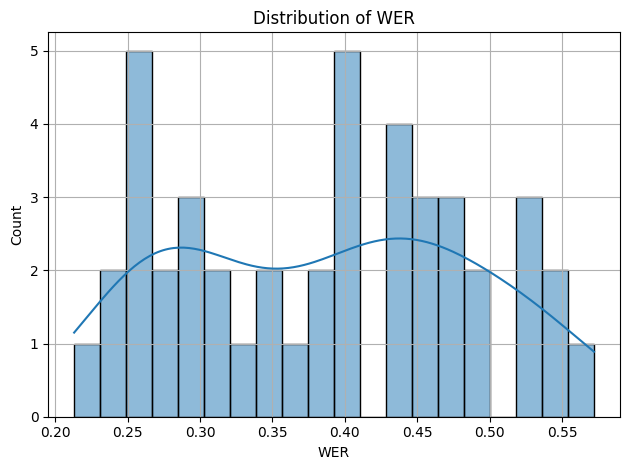

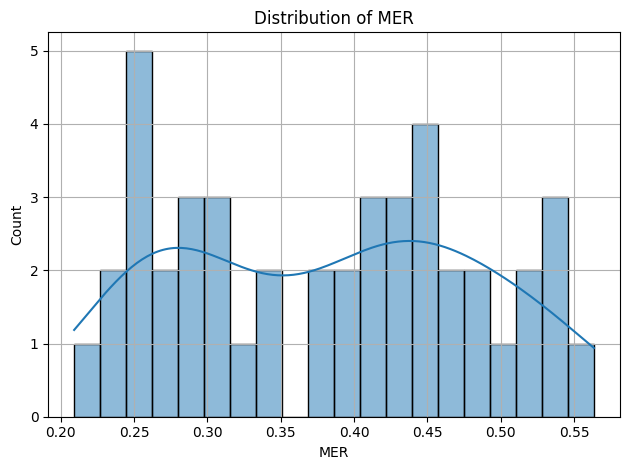

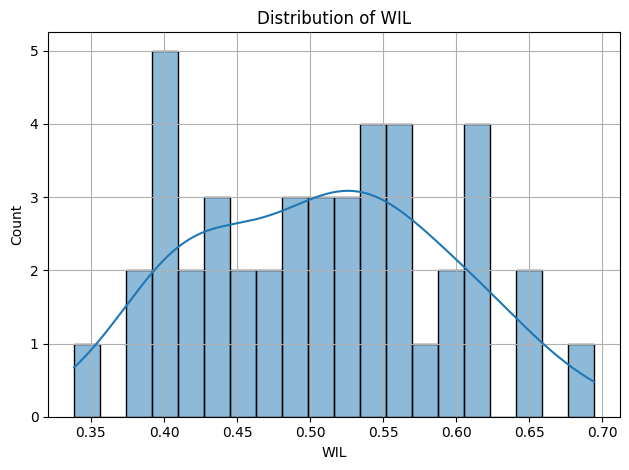

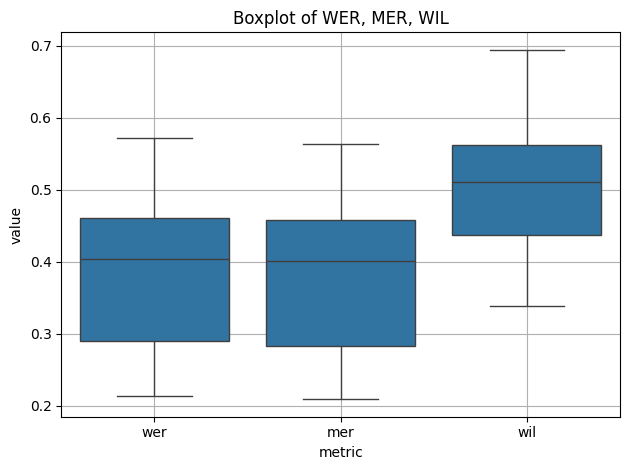

In [ ]:
#Descriptive statistics
print("Descriptive statistics:")
print(df.describe())

#Histograms for each metric
for metric in ['wer', 'mer', 'wil']:
    plt.figure()
    sns.histplot(df[metric], kde=True, bins=20)
    plt.title(f"Distribution of {metric.upper()}")
    plt.xlabel(metric.upper())
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Boxplot to see spread and outliers
plt.figure()
df_melted = df.melt(id_vars='folder', value_vars=['wer', 'mer', 'wil'], var_name='metric', value_name='value')
sns.boxplot(x='metric', y='value', data=df_melted)
plt.title("Boxplot of WER, MER, WIL")
plt.grid(True)
plt.tight_layout()
plt.show()


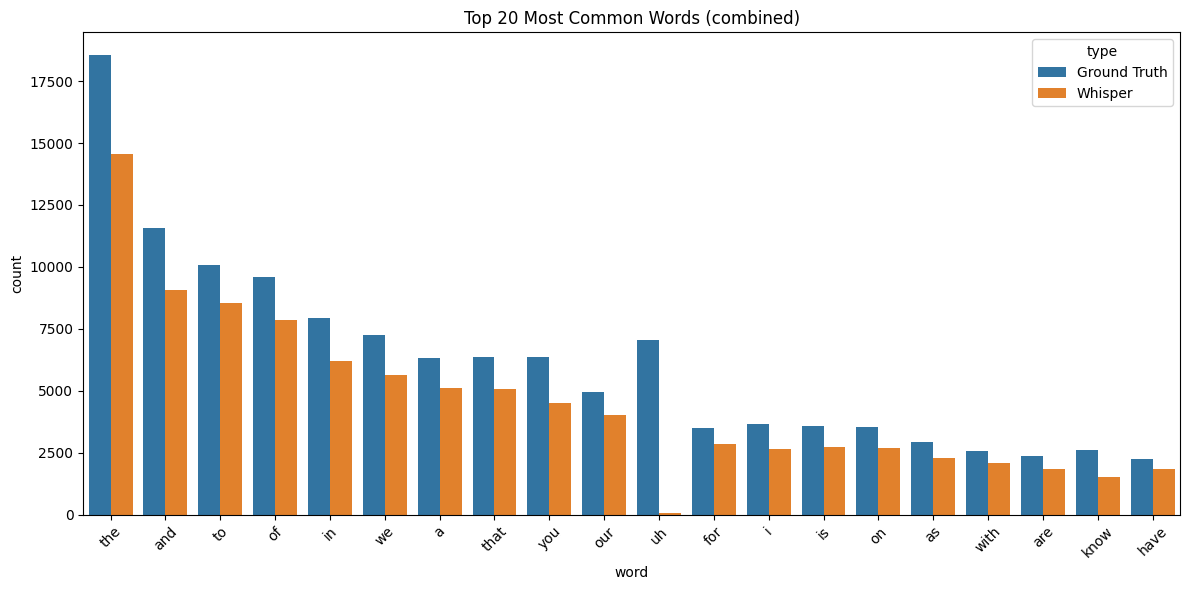

In [23]:

def clean_and_tokenize(text):
    # Lowercase, remove punctuation, split by whitespace
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def get_all_texts(df, colname):
    words = []
    for path in df[colname]:
        with open(path, 'r', encoding='utf-8') as f:
            words += clean_and_tokenize(f.read())
    return words



gt_words = get_all_texts(df_paths, 'gt_path')
hyp_words = get_all_texts(df_paths, 'whisper_path')


gt_counter = Counter(gt_words)
hyp_counter = Counter(hyp_words)

all_words = set(gt_counter) | set(hyp_counter)
combined_freqs = {word: gt_counter[word] + hyp_counter[word] for word in all_words}
top_n = 20
top_words = sorted(combined_freqs.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_words_list = [word for word, _ in top_words]

data = []
for word in top_words_list:
    data.append({'word': word, 'count': gt_counter[word], 'type': 'Ground Truth'})
    data.append({'word': word, 'count': hyp_counter[word], 'type': 'Whisper'})

df_top = pd.DataFrame(data)


plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='word', y='count', hue='type')
plt.title(f"Top {top_n} Most Common Words (combined)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



I want to find filler words that are only in the ground truth but not the transcripts


C:\Users\mark.welin\AppData\Local\Temp\ipykernel_8668\3453342616.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top10, x='rel_diff', y='word', palette='Reds_r')


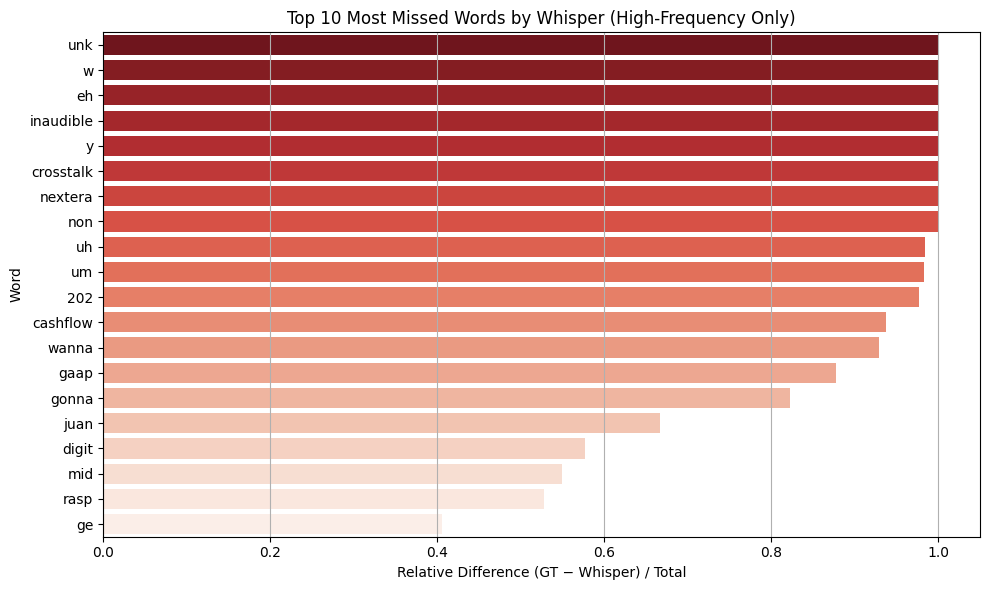

In [37]:
data = []
for word in all_words:
    gt_count = gt_counter[word]
    hyp_count = hyp_counter[word]
    total = gt_count + hyp_count
    if total < 50:
        continue
    rel_diff = (gt_count - hyp_count) / total
    data.append({
        'word': word,
        'gt_count': gt_count,
        'whisper_count': hyp_count,
        'rel_diff': rel_diff
    })

# Convert to DataFrame
df_diff = pd.DataFrame(data)

# Top 10 by relative difference
df_top10 = df_diff.sort_values(by='rel_diff', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top10, x='rel_diff', y='word', palette='Reds_r')
plt.xlabel("Relative Difference (GT − Whisper) / Total")
plt.ylabel("Word")
plt.title("Top 10 Most Missed Words by Whisper (High-Frequency Only)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

In [ ]:
top_words = set(df_top10['word'].tolist())

context_examples = {word: [] for word in top_words}

for path in df_paths['gt_path']:
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read().lower()

    words = re.findall(r'\b\w+\b', text)

    for i, token in enumerate(words):
        if token in top_words:
            start = max(i - 5, 0) # include 5 before
            end = min(i + 6, len(words))  # include the current word and 5 after
            snippet = ' '.join(words[start:end])
            context_examples[token].append(snippet)

# Print one example per word
for word in sorted(top_words):
    examples = context_examples[word]
    if examples:
        print(f"\n Word: '{word}'\nExample: ...{examples[0]}...")
    else:
        print(f"\n Word: '{word}'\nNo example found.")



▶ Word: '202'
Example: ...second half of our fiscal 202 turning to our results for...

▶ Word: 'cashflow'
Example: ...to certain forward looking free cashflow information the comparable gaap and...

▶ Word: 'crosstalk'
Example: ...to the service menu uh crosstalk right crosstalk right yeah it...

▶ Word: 'digit'
Example: ...ll call it a double digit comp improvement off of that...

▶ Word: 'eh'
Example: ...18 months yes and alvaro eh uh um uh thinking about...

▶ Word: 'gaap'
Example: ...company will be discussing non gaap financial measurements a reconciliation of...

▶ Word: 'ge'
Example: ...good morning and welcome to ge s first quarter 2020 earnings...

▶ Word: 'gonna'
Example: ...we certainly believe we re gonna be better than that as...

▶ Word: 'inaudible'
Example: ...the potential long term consumership inaudible the acquisition in nevada and...

▶ Word: 'juan'
Example: ...the call today we have juan esteban calle our ceo carlos...

▶ Word: 'mid'
Example: ...rochester new york

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", and "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

- Removing

In [46]:
print(df_paths)

     folder                                         gt_path  \
0   4320211  Data/revdotcom/combined_21\4320211\4320211.txt   
1   4330115  Data/revdotcom/combined_21\4330115\4330115.txt   
2   4341191  Data/revdotcom/combined_21\4341191\4341191.txt   
3   4344338  Data/revdotcom/combined_21\4344338\4344338.txt   
4   4344866  Data/revdotcom/combined_21\4344866\4344866.txt   
5   4346818  Data/revdotcom/combined_21\4346818\4346818.txt   
6   4346923  Data/revdotcom/combined_21\4346923\4346923.txt   
7   4359732  Data/revdotcom/combined_21\4359732\4359732.txt   
8   4359971  Data/revdotcom/combined_21\4359971\4359971.txt   
9   4360366  Data/revdotcom/combined_21\4360366\4360366.txt   
10  4360674  Data/revdotcom/combined_21\4360674\4360674.txt   
11  4360717  Data/revdotcom/combined_21\4360717\4360717.txt   
12  4361631  Data/revdotcom/combined_21\4361631\4361631.txt   
13  4363614  Data/revdotcom/combined_21\4363614\4363614.txt   
14  4364366  Data/revdotcom/combined_21\4364366\4364366

In [45]:
import re
import difflib
from difflib import SequenceMatcher

# Get the top missed words
top_words = set(df_top10['word'].tolist())
context_examples = {word: [] for word in top_words}

# Map GT paths to Whisper paths
gt_to_whisper = {row['gt_path']: row['whisper_path'] for _, row in df_paths.iterrows()}

for gt_path in df_paths['gt_path']:
    with open(gt_path, 'r', encoding='utf-8') as f_gt, open(gt_to_whisper[gt_path], 'r', encoding='utf-8') as f_whisper:
        gt_text = f_gt.read().lower()
        whisper_text = f_whisper.read().lower()

    # Tokenize GT
    gt_words = re.findall(r'\b\w+\b', gt_text)

    for i, token in enumerate(gt_words):
        if token in top_words:
            start = max(i - 5, 0)
            end = min(i + 6, len(gt_words))
            gt_snippet = ' '.join(gt_words[start:end])

            # Fuzzy match the GT snippet in Whisper text using SequenceMatcher
            matcher = SequenceMatcher(None, whisper_text, gt_snippet)
            match = matcher.find_longest_match(0, len(whisper_text), 0, len(gt_snippet))

            if match.size > 0:
                # Expand to show context around the match
                w_start = max(match.a - 50, 0)
                w_end = min(match.a + match.size + 50, len(whisper_text))
                whisper_match = whisper_text[w_start:w_end]
            else:
                whisper_match = '[No match found]'

            context_examples[token].append((gt_snippet, whisper_match))

# Print one example per top word
for word in sorted(top_words):
    examples = context_examples[word]
    if examples:
        gt_snippet, whisper_snippet = examples[0]
        print(f"\n▶ Word: '{word}'")
        print(f"Ground Truth:   {gt_snippet}")
        print(f"Whisper Output: {whisper_snippet}")
        print("-" * 60)
    else:
        print(f"\n▶ Word: '{word}'")
        print("No example found.")
        print("-" * 60)



▶ Word: '202'
Ground Truth:   second half of our fiscal 202 turning to our results for
Whisper Output: and an update to our targets for the second
 2020. turning to our results for the quarter, we delivered consolidated net econom
------------------------------------------------------------

▶ Word: 'cashflow'
Ground Truth:   to certain forward looking free cashflow information the comparable gaap and
Whisper Output: ments because of various risks and uncertainties.
 comparable gap financial measurement is included as a schedule 
------------------------------------------------------------

▶ Word: 'crosstalk'
Ground Truth:   to the service menu uh crosstalk right crosstalk right yeah it
Whisper Output: think we're actually not adding any new
 products to the service menu.
 right.
 let's go back to your entire store, rig
------------------------------------------------------------

▶ Word: 'digit'
Ground Truth:   ll call it a double digit comp improvement off of that
Whisper Output:  